<a href="https://colab.research.google.com/github/amybecker/borda/blob/master/borda_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
!{sys.executable} -m pip install mip

     |████████████████████████████████| 48.4MB 90kB/s 


In [2]:
!git clone https://github.com/amybecker/borda
%cd borda

Cloning into 'borda'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 72 (delta 7), reused 16 (delta 2), pack-reused 43
Unpacking objects: 100% (72/72), done.
/content/borda


In [3]:
from mip import *
import operator
import itertools
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vote_reader import *

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
#helper functions
def vec_dist(x,places):
    out_sum = 0
    for unit in range(len(units)):
        place_votes_unit = place_votes[unit]
        borda_scores = {cands[units[unit]][cand]:sum([place_votes_unit[cand][i]*x[i] for i in range(len(x))]) for cand in range(len(place_votes_unit))}
        sorted_borda_dict = dict(sorted(borda_scores.items(), key=operator.itemgetter(1), reverse=True))
        borda_vec = list(sorted_borda_dict.keys())
        assert(len(STV_vecs[units[unit]])==len(borda_vec))
        assert(set(STV_vecs[units[unit]])==set(borda_vec))
        a = [STV_vecs[units[unit]].index(c) for c in STV_vecs[units[unit]]]
        b = [STV_vecs[units[unit]].index(c) for c in borda_vec]
        out_sum += (-1*stats.kendalltau(a[:places], b[:places])[0]+1)/2
    return out_sum

def borda_scores(x):
    out_dict = {}
    for unit in range(len(units)):
        place_votes_unit = place_votes[unit]
        scores = {cands[units[unit]][cand]:sum([place_votes_unit[cand][i]*x[i] for i in range(len(x))]) for cand in range(len(place_votes_unit))}
        sorted_borda_dict = dict(sorted(scores.items(), key=operator.itemgetter(1), reverse=True))
        borda_vec = list(sorted_borda_dict.keys())
        out_dict[units[unit]] = {cand:sorted_borda_dict[cand] for cand in borda_vec}
    return out_dict

def borda_vec(x):
    scores_dict = borda_scores(x)
    out_dict = {}
    for unit in units:
        sorted_borda_dict = dict(sorted(scores_dict[unit].items(), key=operator.itemgetter(1), reverse=True))
        out_dict[unit]= list(sorted_borda_dict.keys())
    return out_dict


In [16]:
def mip_solver():
    # Create a new model
    # m = Model(solver_name=CBC)
    m = Model()
    m.integer_tol = 1e-9

    # Create variables
    # borda weights
    w_mat = [0]*n_cand
    for i in range(n_cand):
        if num_pts_total == 1:
            w_mat[i] = m.add_var(lb = 0.0, ub=1, name="w_"+str(i))
        else:
            w_mat[i] = m.add_var(lb = 0, ub=num_pts_total, var_type=INTEGER, name="w_"+str(i))


    # violated_ordered_pairs
    z_mat = [[[0]*n_cand for i in range(n_cand)] for unit in range(len(units))]
    for y in range(len(units)):
        for i in range(n_cand):
            for j in range(n_cand):
                z_mat[y][i][j] = m.add_var(var_type=BINARY, name="z_"+str(y)+'_'+str(i)+'_'+str(j))

    # Add constraints:
    for i in range(len(w_mat)-1):
        m+= w_mat[i]- w_mat[i+1]>= 0, "w_noninc_"+str(i)
    m += w_mat[-1]>= 0, "w_nonneg"

    m += num_pts_total == xsum(w_mat), "w_sum_to_one"

    for y in range(len(units)):
        for i in range(places_of_interest-1):
            for j in range(i+1,places_of_interest,1):
                if STV_places[y][i] < STV_places[y][j]:
                    m+= xsum([place_votes[y][j][k]*w_mat[k] for k in range(n_cand)]) - xsum([place_votes[y][i][k]*w_mat[k] for k in range(n_cand)])<= z_mat[y][i][j]*U - min_score_diff
                else:
                    m+= xsum([place_votes[y][i][k]*w_mat[k] for k in range(n_cand)]) - xsum([place_votes[y][j][k]*w_mat[k] for k in range(n_cand)])<= z_mat[y][i][j]*U - min_score_diff

    # Set objective:
    m.objective = minimize(xsum([xsum([xsum(z_elem) for z_elem in z_unit]) for z_unit in z_mat]))

    status = m.optimize(max_seconds=3600)
    if status == OptimizationStatus.OPTIMAL:
        print('optimal solution cost {} found'.format(m.objective_value))
    elif status == OptimizationStatus.FEASIBLE:
        print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
    elif status == OptimizationStatus.NO_SOLUTION_FOUND:
        print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))

    for elem in w_mat:
        print("optimal "+elem.name+":", elem.x)

    w = [round(elem.x, print_precision) for elem in w_mat]
    w_borda1 = list(range(len(w),0,-1))
    w_borda0 = [w_i - 1 for w_i in w_borda1]
    w_Dowdall = [1/(len(w_borda0)-w_i) for w_i in w_borda0]
    w_MLB_MVP = [14]+[9-i for i in range(9)]
    print("w:", w)
    return w

def print_vector_distances(w):
    print("vector dist (kendall tau) w:", vec_dist(w,places_of_interest))
    print("vector dist (kendall tau) borda_1:", vec_dist(w_borda1,places_of_interest))
    print("vector dist (kendall tau) borda_2:", vec_dist(w_borda0,places_of_interest))
    print("vector dist (kendall tau) Dowdall:", vec_dist(w_Dowdall,places_of_interest))
    print("vector dist (kendall tau) MLB MVP:", vec_dist(w_MLB_MVP,places_of_interest))

def print_target_comparison(w):
    print('borda scores:', borda_scores(w))
    print('targets:', [STV_vecs[unit][:places_of_interest] for unit in units])



In [6]:
def three_weight_heat_map(fix_weight_1, places_of_interest):
    scores = [[0]*(fix_weight_1+1) for i in range(fix_weight_1+1)]
    for i in range(fix_weight_1+1):
        for j in range(fix_weight_1+1):
            scores[i][j] = vec_dist([fix_weight_1,i,j],places_of_interest)
    opt = min([i for j in scores for i in j])
    opt_loc = [(i,j) for i in range(fix_weight_1+1) for j in range(fix_weight_1+1) if scores[i][j]==opt][0]
    plt.title('optimum score:'+ str(round(opt,3))+' @ at: (1st pl: '+str(fix_weight_1)+'  2nd pl:'+str(opt_loc[0])+'  3rd pl: '+str(opt_loc[1])+')')
    plt.figure
    ax = sns.heatmap(scores, linewidth=0,cbar_kws={'label': 'kendall tau'})
    plt.xlabel('3rd place score')
    plt.ylabel('2nd place score')
    plt.show()

def two_weight_heat_map(max_score, places_of_interest):
    scores = [[0]*(max_score+1) for i in range(max_score+1)]
    for i in range(max_score+1):
        for j in range(max_score+1):
            scores[i][j] = vec_dist([i,j],places_of_interest)
    opt = min([i for j in scores for i in j])
    opt_loc = [(i,j) for i in range(max_score+1) for j in range(max_score+1) if scores[i][j]==opt][0]
    plt.figure
    ax = sns.heatmap(scores, linewidth=0,cbar_kws={'label': 'kendall tau'})
    plt.xlabel('2nd place score')
    plt.ylabel('1st place score')
    plt.title('optimum score:'+ str(round(opt,3))+' @ at: (1st pl: '+str(opt_loc[0])+'  2nd pl: '+str(opt_loc[1])+')')
    plt.tight_layout()
    plt.show()

In [14]:
#Settings
#Make adjustments here!!!

election_type = "city_council" # "city_council" or "school_committee"
granularity = "precinct"  # "total" or "precinct"
years = [2017] #list of years to include.  can include any odd years 2003-2017. for all: [2003 + 2*i for i in range(8)]
num_places = -1  # e.g. 9 council members, or top 3 spots,  or -1 if all places
allow_tied_borda = False
print_precision = 4
num_pts_total = 1





In [15]:
#Don't adjust these!

#Setup
if election_type == "city_council":
    [cands, prec_STV_vecs, prec_vote_tallies, STV_vecs, vote_tallies] = load_cambridge_vote_data('city_council', 9, years)
elif election_type == "school_committee":
    [cands, prec_STV_vecs, prec_vote_tallies, STV_vecs, vote_tallies] = load_cambridge_vote_data('school_committee', 6, years)
else:
    print("invalid election type")

if granularity == "precinct":
    STV_vecs = {(year,prec):prec_STV_vecs[year][prec] for year in prec_STV_vecs.keys() if year in years for prec in prec_STV_vecs[year]}
    vote_tallies = {(year,prec):prec_vote_tallies[year][prec] for year in prec_vote_tallies.keys() if year in years for prec in prec_vote_tallies[year]}
    cands = {(year,prec):cands[year] for (year,prec) in vote_tallies.keys() if year in years}
elif granularity == "total":
    STV_vecs = {(year,"total"):STV_vecs[year] for year in STV_vecs.keys() if year in years}
    vote_tallies = {(year,"total"):vote_tallies[year] for year in vote_tallies.keys() if year in years}
    cands = {(year,"total"):cands[year] for year in cands.keys() if year in years}
else:
    print("invalid granularity")

units = list(cands.keys())

n_cand = max([len(STV_vecs[unit]) for unit in units])
#pad for extra candidates/places
for unit in units:
    cands[unit] = cands[unit]+['pad_'+str(i) for i in range(n_cand-len(cands[unit]))]
    STV_vecs[unit] = STV_vecs[unit] + ['pad_'+str(i) for i in range(n_cand-len(STV_vecs[unit]))]
    vote_tallies[unit] = {cand:vote_tallies[unit][cand]+[0 for i in range(n_cand-len(vote_tallies[unit][cand]))] for cand in vote_tallies[unit].keys()}
    vote_tallies[unit].update({c:[0]*n_cand for c in ['pad_'+str(i) for i in range(n_cand-len(vote_tallies[unit].keys()))]})

STV_places = [[STV_vecs[unit].index(cand) for cand in cands[unit]] for unit in units]
place_votes = [[vote_tallies[unit][cand] for cand in cands[unit]] for unit in units]

for i in range(len(units)):
    assert(len(STV_places[i]) == n_cand)
    for votes in place_votes[i]:
        assert(len(votes)== n_cand)

U = 2*num_pts_total*max([max([sum(place_votes[j][i]) for i in range(len(place_votes[j]))]) for j in range(len(units))])
L = -1*U

if allow_tied_borda:
  min_score_diff = 0
elif num_pts_total > 1:
  min_score_diff = 1
else:
  min_score_diff = .1

if num_places == -1:
    places_of_interest = n_cand
else:
    places_of_interest = min(num_places, n_cand)

processing:  2017
processing:  2017 000703
******* WARNING: threshold not passed *******
processing:  2017 000601
processing:  2017 000402
******* WARNING: threshold not passed *******
processing:  2017 000303
******* WARNING: threshold not passed *******
processing:  2017 000304
******* WARNING: threshold not passed *******
processing:  2017 000203
******* WARNING: threshold not passed *******
processing:  2017 000502
******* WARNING: threshold not passed *******
processing:  2017 000702
******* WARNING: threshold not passed *******
processing:  2017 000901
processing:  2017 000501
******* WARNING: threshold not passed *******
processing:  2017 001002
processing:  2017 000602
******* WARNING: threshold not passed *******
processing:  2017 000301
******* WARNING: threshold not passed *******
processing:  2017 001102
processing:  2017 000803
******* WARNING: threshold not passed *******
processing:  2017 000603
******* WARNING: threshold not passed *******
processing:  2017 001003
*****

In [17]:
w = mip_solver()  #this may take a while. especially if using 'precinct' granularity

sol.cost 637.0 found, best possible: 128.87548630061346
optimal w_0: 0.7749999999999995
optimal w_1: 0.17499999999999982
optimal w_2: 0.05000000000000001
optimal w_3: 0.0
optimal w_4: 0.0
optimal w_5: 0.0
optimal w_6: 0.0
optimal w_7: 0.0
optimal w_8: 0.0
optimal w_9: 0.0
optimal w_10: 0.0
optimal w_11: 0.0
optimal w_12: 0.0
optimal w_13: 0.0
optimal w_14: 0.0
optimal w_15: 0.0
optimal w_16: 0.0
optimal w_17: 0.0
optimal w_18: 0.0
optimal w_19: 0.0
optimal w_20: 0.0
optimal w_21: 0.0
optimal w_22: 0.0
optimal w_23: 0.0
optimal w_24: 0.0
optimal w_25: 0.0
w: [0.775, 0.175, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
print_vector_distances(w)

In [ ]:
print_target_comparison(w)

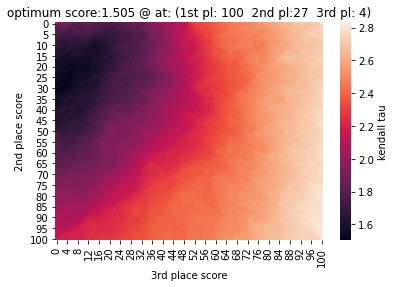

In [12]:
three_weight_heat_map(100, 20)

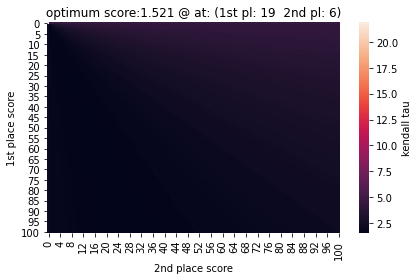

In [13]:
two_weight_heat_map(100, 20)